In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['mystyle', 'mystyle-paper', 'mystyle-vega'])
import pyFLUT
import coal_calculation
import os
import numpy as np
import glob

cycler = plt.rcParams['axes.prop_cycle']
colors = [i['color'] for i in cycler]

In [2]:
import direct_analysis as da

Z_st=0.095


In [3]:
pv = {'CO': 1, 'CO2': 1}
# read ULF files
coal1D = [pyFLUT.read_ulf(f)
         for f in glob.iglob(os.path.join(da.dc_dir, 'coal1D_alpha*.ulf'))]
coal1D = sorted(coal1D, key=lambda c: sum(c.variables.values()))
#print(coal1D)

for c in coal1D:
    c['alpha0'] = c['M_p'] / c['rho']

In [4]:
def set_ax(ax):
    if not ax:
        ax = plt.subplots()
    return ax

def stagnation(coal, ax):
    index = coal['n_p'] == 0
    X_stg = coal['X'][np.where(index)][0]
    ax.axvline(X_stg, linestyle='dashed', color='darkgray')
    return X_stg, ~index

arr_th = 0.0025
def plot_arrow(ax, pos=(0, 0), color=None, direction='right'):
    # axt.arrow(X[index], hMean[index], arr_th, 0,
    #          color=colors[2], length_includes_head=True)
    if direction == 'left':
        shift = -arr_th
    else:
        shift = arr_th
    ax.annotate("", xytext=pos, xy=(pos[0] + shift, pos[1]),
                arrowprops=dict(arrowstyle='-|>', color=color, linewidth=1))


In [5]:
def plot_coal_status(coal, n=1, ax=None):
    '''Plot coal'''
    ax = set_ax(ax)
    X_stg, stg_index = stagnation(coal, ax)
    X = coal['X'][stg_index]
    ax.plot(X, coal['alpha0'][stg_index], label='$\\alpha$', 
            color=colors[0])
    
    ax.plot(X, coal['m_volatiles'][stg_index]/coal['m_volatiles'][0],
           label='$Y_v/Y_{v,0}$', color=colors[1])
    
    ax.set_ylim([0, 1.5])
    ax.locator_params(axis='y', nbins=3)
    
    if n == 0:
        ax.set_ylabel('')
        ax.legend(loc='upper left')
    
    return ax

In [6]:
def plot_temperature(coal, n=1, ax=None):
    ax = set_ax(ax)
    X_stg, stg_index = stagnation(coal, ax)
    X = coal['X']
    ax.plot(X, coal['T'], label='$T_g$', color=colors[0])
    ax.plot(X[stg_index], coal['T_p'][stg_index], label='$T_p$', 
            color=colors[1])
    
    if n == 0:
        ax.set_ylabel('')
        ax.legend(loc='best')
        ax.set_ylabel('Temperature, K')
    ax.locator_params(axis='y', nbins=4)
    
    return ax
    

In [7]:
species = ['C6H6', 'CO', 'CO2', 'H2O', 'O2']
species_label = ['$C_6H_6$', '$CO$', '$CO_2$', '$H_2O$', '$O_2$']
def plot_species(coal, n=1, ax=None):
    ax = set_ax(ax)
    X = coal['X']
    for sp, col in zip(species, colors):
        ax.plot(X, coal[sp], color=col)
    
    
    if n == 0:
        ax.set_ylabel('Mass fractions')
    elif n == 2:
        ax.legend(species_label, loc='upper left',
                  bbox_to_anchor=(1.02, 1))

    ax.locator_params(axis='y', nbins=5)
    X_stg, stg_index = stagnation(coal, ax)
    return ax
    

In [8]:
def plot_mixture_fraction(coal, n=1, ax=None):
    ax = set_ax(ax)
    X_stg, stg_index = stagnation(coal, ax)
    # coal.plotdata('X', 'Z', legend=False, ax=ax, label='$Z$', color=colors[0])
    ax.plot(coal['X'], coal['Z'], label='$Z$', color=colors[0])
    ax.axhline(da.Z_st, linestyle='dashed', color='darkgray')
    # label for stoichiometric line
    if n == 0:
        ax.annotate("$Z_{st}$", xytext=(0.005, da.Z_st + 0.03),
                    xy=(0.001, da.Z_st), arrowprops=dict(arrowstyle='-|>',
                                                        linewidth=1,
                                                        color='black'))
    # arrow to Z axis
    index = coal['Z'].argmax() - 40
    plot_arrow(ax, pos=(coal['X'][index], coal['Z'][index]), color=colors[0],
               direction='left')
    
    # create another y axis on the right
    ax1 = ax.twinx()
    ax1.plot(coal['X'], coal['chi'], label='$\chi$', color=colors[1])
    
    if n != 0:
        index = coal['chi'].argmax()
        plot_arrow(ax1, pos=(coal['X'][index], coal['chi'][index]), 
                   color=colors[1], direction='right')
    
    if n == 0:
        ax.set_ylabel('$Z$', color=colors[0])
        ax.tick_params(axis='y', colors=colors[0])
        
    if n == 2:
        ax1.set_ylabel('$\chi$, 1/s', color=colors[1])
        ax1.tick_params(axis='y', colors=colors[1])
    else:
        ax1.set_ylabel('')
        ax1.set_yticklabels([])
        
    ax1.set_ylim([0, 25])
    ax.set_ylim([0, 0.25])
    n_bins = 5
    ax1.locator_params(axis='y', nbins=5)
    ax.locator_params(axis='y', nbins=5) 
    return ax
    

In [9]:
def plot_cema(coal, n=1, ax=None):
    ax = set_ax(ax)
    X_st, stg_index = stagnation(coal, ax)
    cem = '$\gamma_{e}$, 1/s'
    
    # define a point for the zero-crossing
    X = coal['X']
    cema = coal['CEMA']
    X_cemapeak = X[cema.argmax()]
    index = (X > X_cemapeak) & (X < X_st)
    X = X[index]
    cema = cema[index]
    X_cross = X[cema >= 0][-1]
    ax.plot([X_cross], [0], marker='o', color=colors[0],
            markeredgecolor=colors[0], markersize=8)
    ax.axhline(0, color=colors[0], linestyle='dashed')
    if n == 0:
        ax.annotate("zero-crossing", xytext=(X_cross + 0.005, 5),
                    xy=(X_cross, 0), arrowprops=dict(arrowstyle='-|>',
                                                     linewidth=1,
                                                     color='black'))
    # plot cema
    ax.plot(coal['X'], coal['CEMA'], color=colors[0])
    
    # plot arrow
    index = coal['CEMA'].argmax()
    pos = (coal['X'][index], coal['CEMA'][index])
    plot_arrow(ax, pos=pos, color=colors[0], direction='left')

    # create another y axis on the right
    ax1 = ax.twinx()
    hrr = -coal['HRR'] * 1e-6
    ax1.plot(coal['X'], hrr, color=colors[1])
    # arrow
    index = hrr.argmax()
    pos = (coal['X'][index], hrr[index])
    plot_arrow(ax1, pos=pos, color=colors[1], direction='right')
    
    if n == 0:
        ax.set_ylabel(cem, color=colors[0])
        ax.tick_params(axis='y', colors=colors[0])
    if n == 2:
        ax1.set_ylabel('$\Omega_T$, W', color=colors[1])
        ax1.tick_params(axis='y', colors=colors[1])
    else:
        ax1.set_ylabel('')
        ax1.set_yticklabels([])
    
    ax1.set_ylim([-1000, 3000])
    ax.set_ylim([-10, 10])
    n_bins = 5
    ax1.locator_params(axis='y', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    
    return ax
    

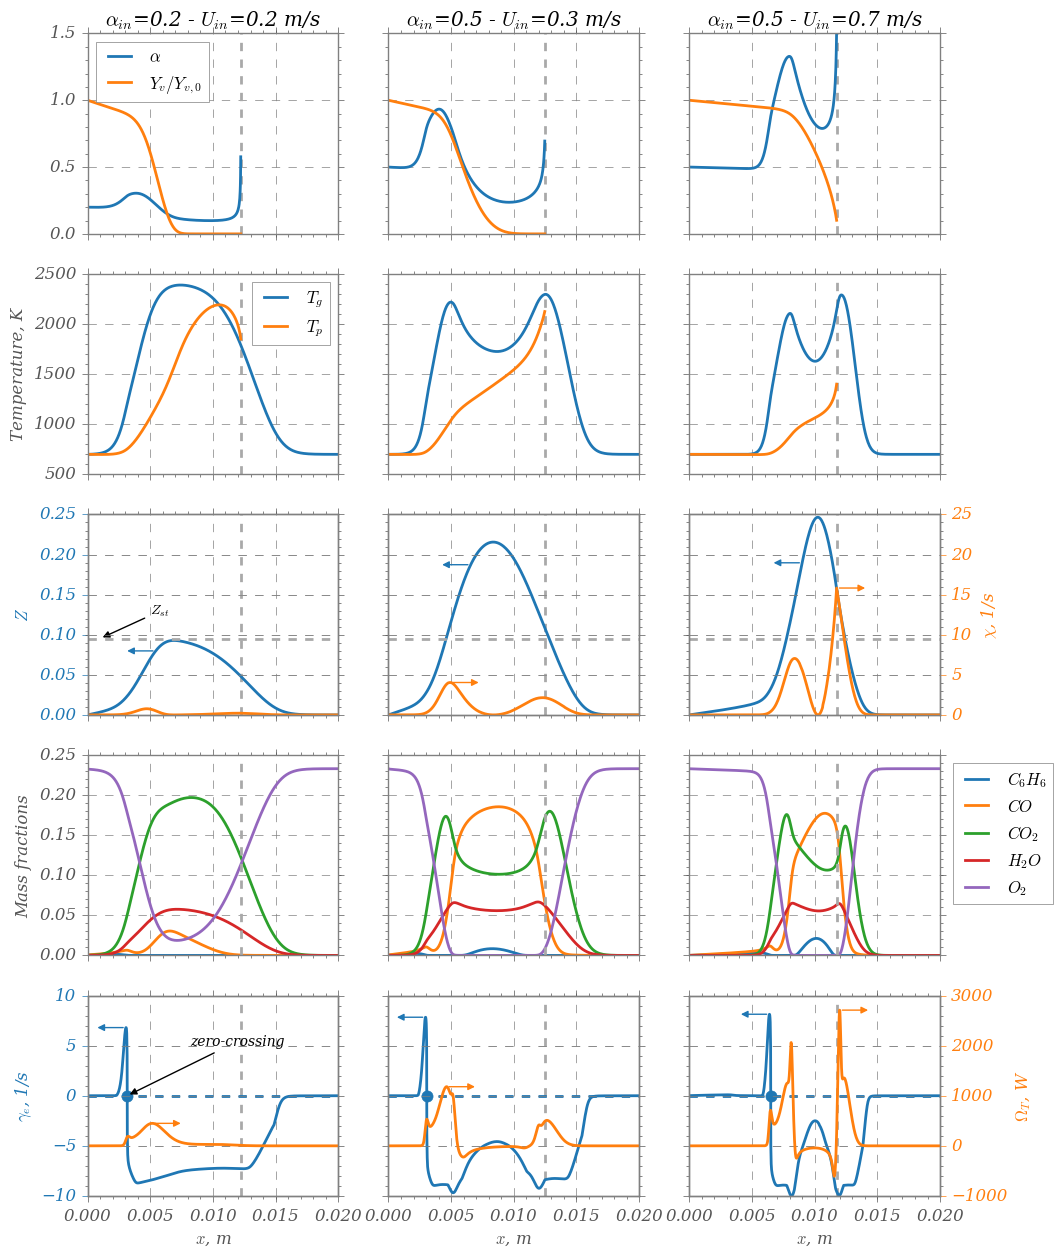

In [10]:
L, H = 11, 3
titles = ['$\\alpha_{in}$=0.2 - $U_{in}$=0.2 m/s',
          '$\\alpha_{in}$=0.5 - $U_{in}$=0.3 m/s',
          '$\\alpha_{in}$=0.5 - $U_{in}$=0.7 m/s']
plot_fcts = [plot_coal_status,
             plot_temperature,
             plot_mixture_fraction,
             plot_species,
             plot_cema
            ]
n_rows = len(plot_fcts)
fig, axes = plt.subplots(ncols=len(coal1D), nrows=n_rows, sharey='row', 
                        sharex='col', figsize=(L, H * n_rows))

for n_row, (fct, axes_row) in enumerate(zip(plot_fcts, axes)):
    for n_col, (c, ax) in enumerate(zip(coal1D, axes_row)):
        fct(c, n_col, ax=ax)

# Write titles at the top of the first row plots
for i, t in enumerate(titles):
    axes[0][i].set_title(t)
        
# write x label for the bottom plots
for ax in axes[-1]:
    ax.set_xlabel('$x$, m')
    ax.set_xlim([0, 0.02])

In [11]:
fig.savefig('direct_analysis.pdf', dpi=80, bbox_inches='tight')